# Multivariate State Space Model using TensorFlow

In [1]:
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 16.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120258 sha256=94046e253c400b58e3621775b90a486d0de69c9c4be91048939005908d9036d1
  Stored in directory: /Users/yuta.sonoda/Library/Caches/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


In [1]:
%matplotlib inline
import collections

import japanize_matplotlib
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from pandas.plotting import register_matplotlib_converters
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

# 2023/04/02: MacOS M1 chip で Adam を optimizer にして ELBO 最小化ができない.
#  一方で, 以下ページに記載されているモデルは実行可能.
#  https://developer.apple.com/forums/thread/721735
# ToDo: MacOS で実行する場合には GPU ではなく CPU で実行する必要があるかどうか確認してコーディング.
tf.config.set_visible_devices([], 'GPU')

In [31]:
def plot_forecast(
    x,
    y,
    forecast_mean,
    forecast_scale,
    forecast_samples,
    title,
    x_locator=None,
    x_formatter=None,
):
    """Plot forecasting distribution to the true time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast
    
    ax.plot(x, y, lw=2, color=c1, label="ground truth")
    
    forecast_steps = np.arange(
        x[num_steps_train],
        x[num_steps_train] + num_steps_forecast,
        dtype=x.dtype,
    )
    
    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=.1)
    ax.plot(forecast_steps, forecast_mean, lw=2, ls="--", color=c2, label="forecast")
    ax.fill_between(
        forecast_steps,
        forecast_mean - 2 * forecast_scale,
        forecast_mean + 2 * forecast_scale,
        color=c2,
        alpha=.2,
    )
    
    ymin = min(np.min(forecast_samples), np.min(y))
    ymax = max(np.max(forecast_samples), np.max(y))
    yrange = ymax - ymin
    ax.set_ylim([ymin - yrange * 0.1, ymax + yrange * 0.1])
    ax.set_title("{}".format(title))
    ax.legend()
    
    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
        
    return fig, ax

In [3]:
def plot_components(
    dates,
    component_means_dict,
    component_stddevs_dict,
    x_locator=None,
    x_formatter=None,
):
    """Plot the contributions of posterior components in a single figure."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    
    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig, axes = plt.subplots(num_components, 1, figsize=(12, 2.5 * num_components))
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]
        
        ax = axes[i]
        ax.plot(dates, component_mean, lw=2)
        ax.fill_between(
            dates,
            component_mean - 2 * component_stddev,
            component_mean + 2 * component_stddev,
            color=c2,
            alpha=.5,
        )
        ax.set_title(component_name)
        if x_locator is not None:
            ax.xaxis.set_major_locator(x_locator)
            ax.xaxis.set_major_formatter(x_formatter)
        axes_dict[component_name] = ax
    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, axes_dict

In [4]:
def plot_one_step_predictive(
    dates,
    observed_time_series,
    one_step_mean,
    one_step_scale,
    x_locator=None,
    x_formatter=None,
):
    """Plot time series to a model's one-step predictions."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    
    fig, ax = plt.subplots(1, 1, figsize=(12,6))
    num_timesteps = one_step_mean.shape[-1]
    ax.plot(dates, observed_time_series, label="observed time series", color=c1)
    ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
    ax.fill_between(
        dates,
        one_step_mean - one_step_scale,
        one_step_mean + one_step_scale,
        alpha=.1,
        color=c2,
    )
    ax.legend()
    
    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
    fig.tight_layout()
    return fig, ax

In [5]:
data = pd.read_csv("web_access.csv")
data = data.iloc[::-1]
data = data.reset_index(drop=True)
data.head()

,日付,クリック数,表示回数,CTR,掲載順位
0,2020-01-03,34,406,8.37%,21.20
1,2020-01-04,28,387,7.24%,20.01
2,2020-01-05,63,706,8.92%,14.29
3,2020-01-06,97,1024,9.47%,13.00
4,2020-01-07,77,901,8.55%,14.99


In [6]:
click = data["クリック数"].values.astype(np.float64)
view = data["表示回数"].values.astype(np.float64)
rank = data["掲載順位"].values.astype(np.float64)

num_forecast_steps = 28
click_training_data = click[:-num_forecast_steps]

dates = np.arange(
    "2020-01-03",
    "2021-05-03",
    np.timedelta64(1, "D"),
    dtype="datetime64",
)
loc = mdates.MonthLocator()
fmt = mdates.DateFormatter("%a %b %d")

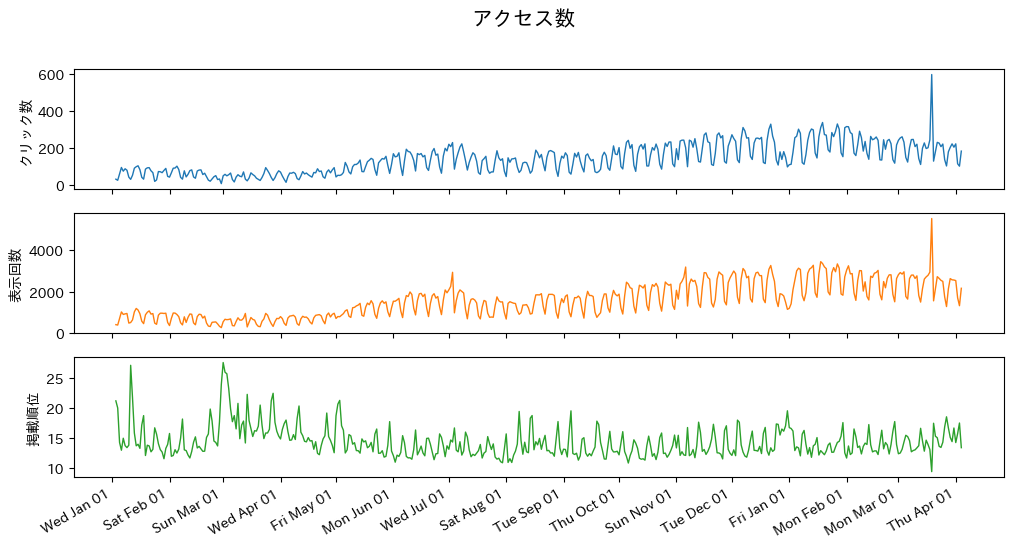

In [7]:
colors = sns.color_palette()
c1, c2, c3 = colors[0], colors[1], colors[2]

fig, axes = plt.subplots(3, 1, figsize=(12, 6))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]

ax1.plot(
    dates[:-num_forecast_steps],
    click[:-num_forecast_steps],
    lw=1,
    label="training data", 
    c=c1,
)
ax1.set_ylabel("クリック数")
ax1.xaxis.set_major_locator(loc)
ax1.xaxis.set_major_formatter(fmt)

ax2.plot(
    dates[:-num_forecast_steps],
    view[:-num_forecast_steps],
    lw=1,
    label="training data", 
    c=c2,
)
ax2.set_ylabel("表示回数")
ax2.xaxis.set_major_locator(loc)
ax2.xaxis.set_major_formatter(fmt)

ax3.plot(
    dates[:-num_forecast_steps],
    rank[:-num_forecast_steps],
    lw=1,
    label="training data", 
    c=c3,
)
ax3.set_ylabel("掲載順位")
ax3.xaxis.set_major_locator(loc)
ax3.xaxis.set_major_formatter(fmt)

fig.suptitle("アクセス数", fontsize=15)
fig.autofmt_xdate()
plt.show()

In [8]:
def build_model(observed_time_series):
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    day_of_week_effect = sts.Seasonal(
        num_seasons=7,
        # 参考ページでは以下を入力しているが, 日別データであることを鑑みると
        #  正確でない気がするためコメントアウト対応.
        # num_steps_per_season=24,
        observed_time_series=observed_time_series,
        name="day_of_week_effect",
    )
    
    view_effect = sts.LinearRegression(
        design_matrix=tf.reshape(view - np.mean(view), shape=(-1, 1)),
        name="view_effect",
    )
    
    rank_effect = sts.LinearRegression(
        design_matrix=tf.reshape(rank - np.mean(rank), shape=(-1, 1)),
        name="rank_effect",
    )
    
    autoregressive = sts.Autoregressive(
        order=1,
        observed_time_series=observed_time_series,
        name="autoregressive",
    )
    
    model = sts.Sum(
        [
            trend,
            day_of_week_effect,
            view_effect,
            rank_effect,
            autoregressive,
        ],
        observed_time_series=observed_time_series
    )
    
    return model

In [9]:
click_model = build_model(click_training_data)

In [10]:
variational_posteriors = sts.build_factored_surrogate_posterior(model=click_model)

In [12]:
num_variational_steps = int(200)
optimizer = tf.optimizers.Adam(learning_rate=.1)

@tf.function(jit_compile=True)
def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=click_model.joint_distribution(
            observed_time_series=click_training_data
        ).log_prob,
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps,
    )
    return elbo_loss_curve

num_steps = int(200)
optimizer = tf.optimizers.Adam(learning_rate=.1)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2023-04-02 20:07:55.737764: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-02 20:07:55.737903: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x174d41090 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-02 20:07:55.737907: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2023-04-02 20:07:55.883083: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/StatefulPartitionedCall/monte_carlo_variational_loss/default_joint_bijectorJointDistributionNamedAutoBatched_CONSTRUCTED_AT_monte_carlo_variational_loss_build_factored_surrogate_posterior_1/sample_and_log_prob/JointDistributionNamedAutoBatched/sample_and_log_prob/sanitize_seed/seed
2023-04-

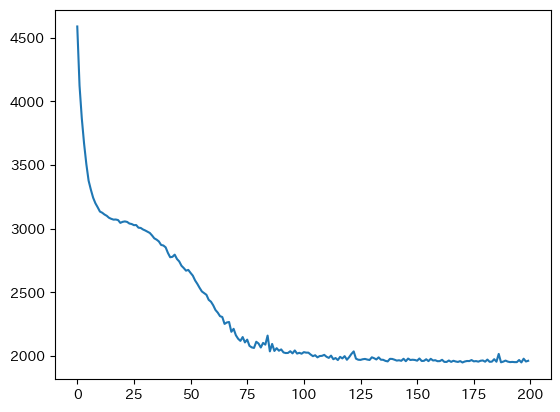

CPU times: user 23.6 s, sys: 5.48 s, total: 29.1 s
Wall time: 17.7 s


In [13]:
%%time
elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.show()

q_sample_demand_ = variational_posteriors.sample(50)

In [22]:
def print_params(parameters_samples):
    for name, value in parameters_samples.items():
        if value.ndim == 1:
            print(f"{name:40}: {np.mean(value, axis=0):.2f} ± {np.std(value, axis=0):.2f}")
        else:
            print(f"{name:40}: {np.mean(value, axis=0)[0]:.2f} ± {np.std(value, axis=0)[0]:.2f}")
        
print_params(q_sample_demand_)

observation_noise_scale                 : 14.10 ± 0.44
LocalLinearTrend/_level_scale           : 1.62 ± 0.80
LocalLinearTrend/_slope_scale           : 0.07 ± 0.02
day_of_week_effect/_drift_scale         : 0.75 ± 0.34
view_effect/_weights                    : 0.08 ± 0.00
rank_effect/_weights                    : -1.18 ± 0.39
autoregressive/_coefficients            : 0.36 ± 0.32
autoregressive/_level_scale             : 4.07 ± 1.22


In [23]:
demand_forecast_dist = sts.forecast(
    model=click_model,
    observed_time_series=click_training_data,
    parameter_samples=q_sample_demand_,
    num_steps_forecast=num_forecast_steps,
)

In [24]:
num_samples = 10

(
    demand_forecast_mean,
    demand_forecast_scale,
    demand_forecast_samples,
) = (
    demand_forecast_dist.mean().numpy()[..., 0],
    demand_forecast_dist.stddev().numpy()[..., 0],
    demand_forecast_dist.sample(num_samples).numpy()[..., 0],
)

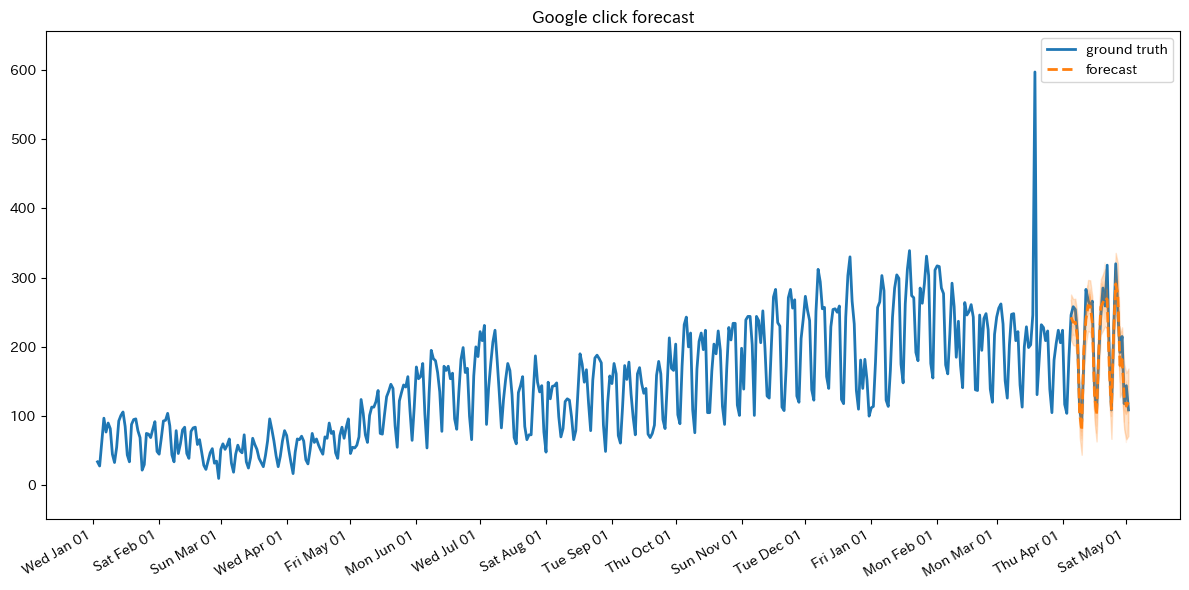

In [32]:
fig, ax = plot_forecast(
    dates,
    click,
    demand_forecast_mean,
    demand_forecast_scale,
    demand_forecast_samples,
    title="Google click forecast",
    x_locator=loc,
    x_formatter=fmt,
)
fig.tight_layout()
plt.show()

In [33]:
component_dists = sts.decompose_by_component(
    click_model,
    observed_time_series=click_training_data,
    parameter_samples=q_sample_demand_,
)

forecast_component_dists = sts.decompose_forecast_by_component(
    click_model,
    forecast_dist=demand_forecast_dist,
    parameter_samples=q_sample_demand_
)

In [34]:
(
    demand_component_means_, 
    demand_component_stddevs_,
) = (
    {k.name: v.mean() for k, v in component_dists.items()},
    {k.name: v.stddev() for k, v in component_dists.items()},
)

(
    demand_forecast_component_means_, 
    demand_forecast_component_stddevs_,
) = (
    {k.name: v.mean() for k, v in forecast_component_dists.items()},
    {k.name: v.stddev() for k, v in forecast_component_dists.items()},
)

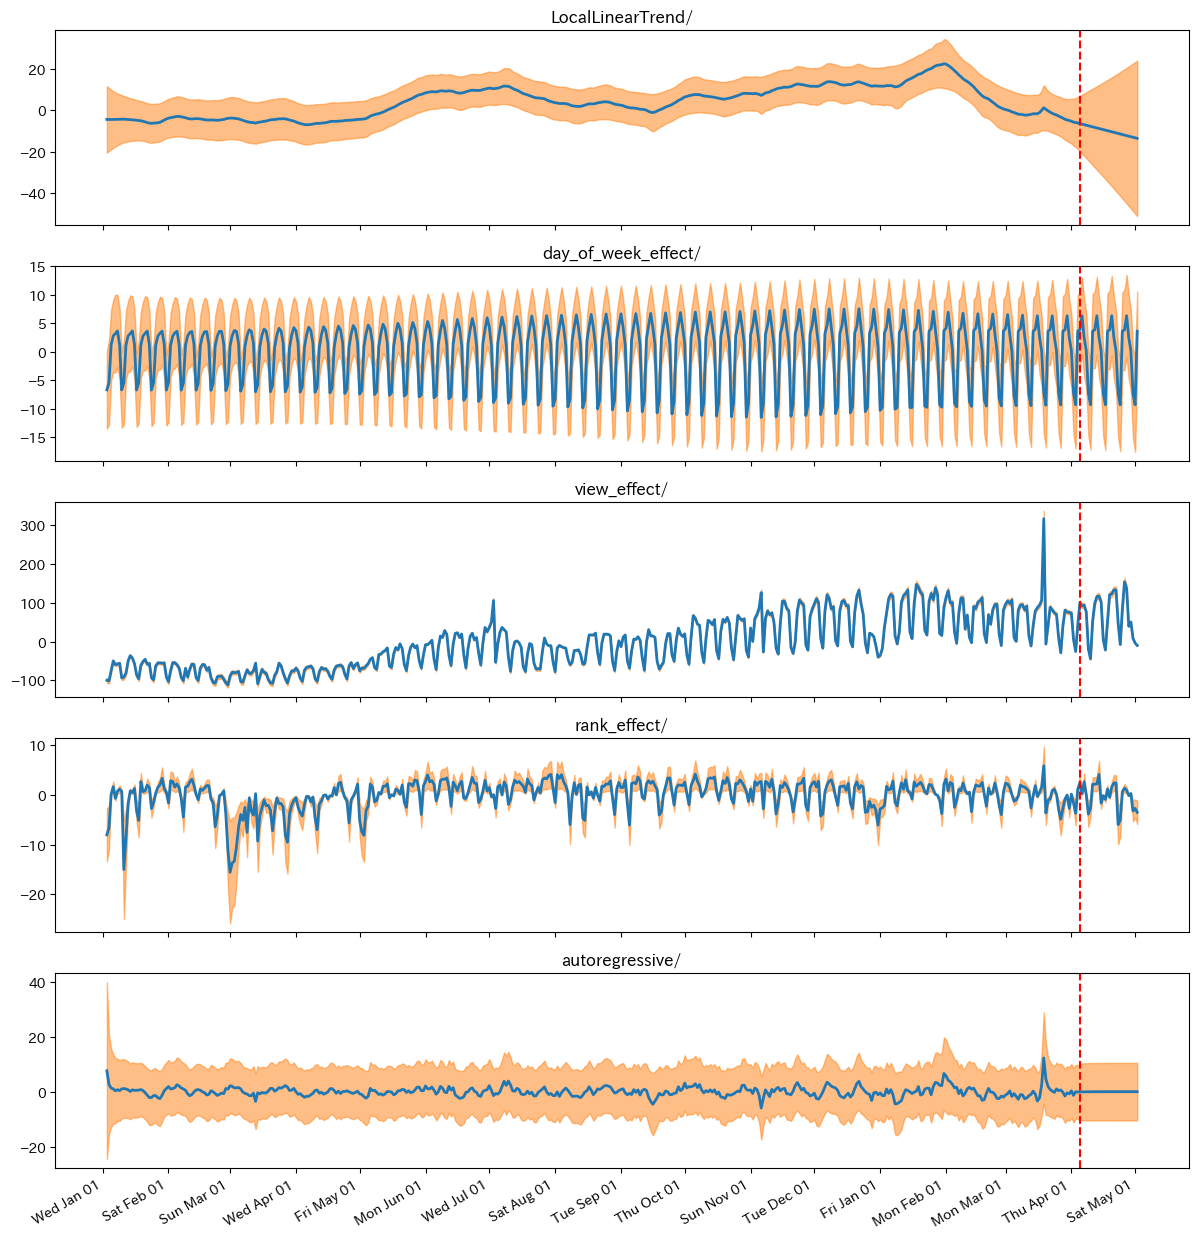

In [35]:
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in demand_component_means_.keys():
    component_with_forecast_means_[k] = np.concatenate(
        [
            demand_component_means_[k],
            demand_forecast_component_means_[k],
        ], 
        axis=-1,
    )
    component_with_forecast_stddevs_[k] = np.concatenate(
        [
            demand_component_stddevs_[k],
            demand_forecast_component_stddevs_[k],
        ],
        axis=-1,
    )
    
fig, axes = plot_components(
    dates,
    component_with_forecast_means_,
    component_with_forecast_stddevs_,
    x_locator=loc,
    x_formatter=fmt,
)
for ax in axes.values():
    ax.axvline(dates[-num_forecast_steps], ls="--", c="r")

In [36]:
demand_one_step_dist = sts.one_step_predictive(
    click_model,
    observed_time_series=click,
    parameter_samples=q_sample_demand_,
)

(
    demand_one_step_mean,
    demand_one_step_scale,
) = (
    demand_one_step_dist.mean().numpy(),
    demand_one_step_dist.stddev().numpy(),
)

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


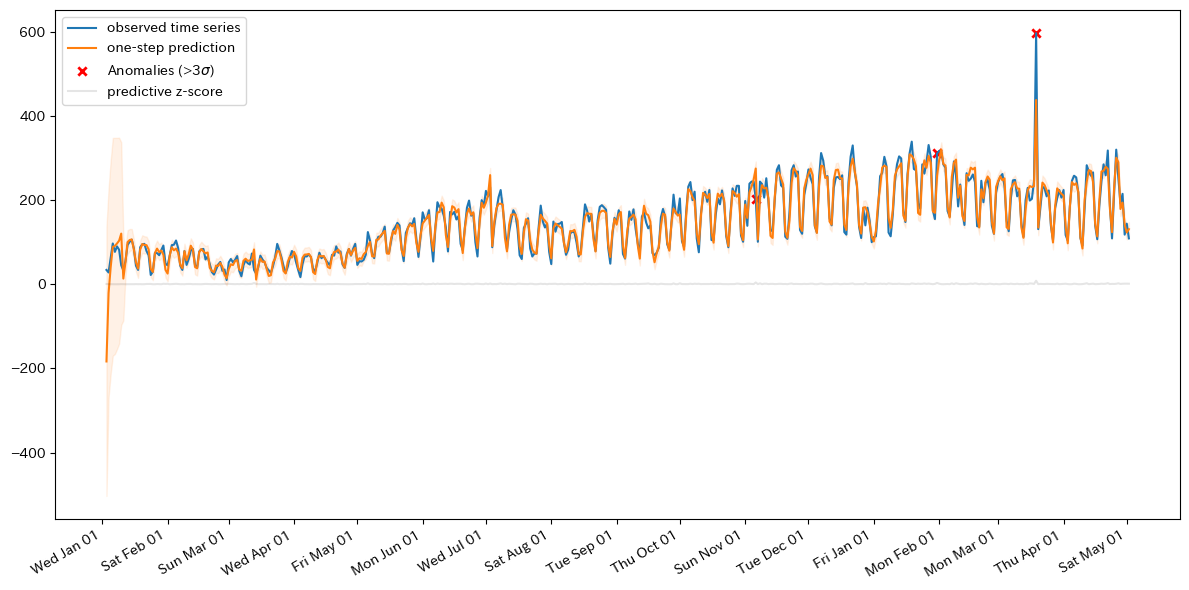

In [42]:
fig, ax = plot_one_step_predictive(
    dates,
    click,
    demand_one_step_mean,
    demand_one_step_scale,
    x_locator=loc,
    x_formatter=fmt,
)

zscores = np.abs((click - demand_one_step_mean) / demand_one_step_scale)
anomalies = zscores > 3.0
ax.scatter(
    dates[anomalies],
    click[anomalies],
    c="r",
    marker="x",
    lw=2,
    label=r"Anomalies (>3$\sigma$)",
)
ax.plot(dates, zscores, c="black", alpha=.1, label="predictive z-score")
ax.legend()
plt.show()